<a href="https://colab.research.google.com/github/medamer/Build-Week-2/blob/master/BuildWeek_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#DETECTING ALZHEIMER'S USING MACHINE LEARNING:

##ALZHEIMER'S DISEASE:
Alzheimer's disease is a progressive disorder that causes brain cells to waste away (degenerate) and die. Alzheimer's disease is the most common cause of dementia — a continuous decline in thinking, behavioral and social skills that disrupts a person's ability to function independently.

There is no treatment that cures Alzheimer's disease or alters the disease process in the brain. The available medications can only temporarily improve symptoms or slow the rate of decline. These treatments can sometimes help people with Alzheimer's disease maximize function and maintain independence for a time.

##Data:
Longitudinal MRI Data in Nondemented and Demented Older Adults: This set consists of a longitudinal collection of 1968 subjects aged between 60 to 98. Each subject was scanned on two or more visits, separated by at least one year for a total of 2508 imaging sessions.

In [0]:
import pandas as pd

In [2]:
# Install the packages:
!pip install category_encoders==2.*
!pip install pdpbox
!pip install shap

     |████████████████████████████████| 81kB 2.3MB/s 
     |████████████████████████████████| 57.7MB 70kB/s 
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690722 sha256=93b1126cd177be19710a2a68ba007dadf24848c7924c75efa5a2680a08f93d64
  Stored in directory: /root/.cache/pip/wheels/7d/08/51/63fd122b04a2c87d780464eeffb94867c75bd96a64d500a3fe
Successfully built pdpbox
     |████████████████████████████████| 276kB 2.7MB/s 
  Created wheel for shap: filename=shap-0.35.0-cp36-cp36m-linux_x86_64.whl size=394114 sha256=e22f772c81b41fd19bbcea1d7350705e0dafa3dbd6459630a339239f0ec577f9
  Stored in directory: /root/.cache/pip/wheels/e7/f7/0f/b57055080cf8894906b3bd3616d2fc2bfd0b12d5161bcb24ac
Successfully built shap


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/medamer/Datasets/master/oasis_longitudinal.csv')
# Drop unusable columns:
unusable = ['MR Delay','Hand','CDR']
df = df.drop(columns=unusable)
df.shape

(2507, 12)

# Data Explorating:
##COLUMNS DESCRIPTOR:

`Subject ID : Patient ID`

`MRI ID     : Patient ID + The visit number`

`Group      : The conclusion (target)`

`Visit      : The visit number`

`M/F        : Gender`

`Age        : Age`

`EDUC       : Years of education`

`SES        : Socioeconomic Status`

`MMSE       : Mini Mental State Examination`

`eTIV       : Estimated Total Intracranial Volume`

`nWBV       : Normalize Whole Brain Volume`

`ASF        : Atlas Scaling Factor`

In [4]:
df.head()

,Subject ID,MRI ID,Group,Visit,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,M,87,14,2,27,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,M,88,14,2,30,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,M,75,12,4,23,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,M,76,12,3,28,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,M,80,12,2,22,1698,0.701,1.034


In [5]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Subject ID,2507,1968,OAS2_0048,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MRI ID,2507,2507,OAS2_0710_MR1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Group,2507,3,Nondemented,1277,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Visit,2507,NaN,NaN,NaN,1.286,0.622772,1,1,1,1,5
M/F,2507,2,F,1443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,2507,NaN,NaN,NaN,76.8787,7.55055,60,71,77,82,98
EDUC,2507,NaN,NaN,NaN,14.6661,2.90166,6,12,15,17,23
SES,2507,NaN,NaN,NaN,2.5014,1.13859,1,2,2,3,5
MMSE,2507,NaN,NaN,NaN,27.5102,3.53765,4,27,29,30,30
eTIV,2507,NaN,NaN,NaN,1488.72,175.154,1106,1359,1464,1599,2004


# Data Wrangling:

In [6]:
# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from pdpbox import pdp
from pdpbox.pdp import pdp_interact, pdp_interact_plot
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Nondemented    0.509374
Demented       0.369366
Converted      0.121260
Name: Group, dtype: float64


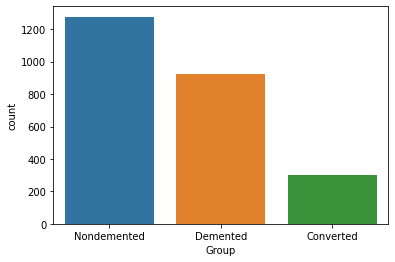

In [7]:
# Baseline:
target='Group'
y=df[target]
print(y.value_counts(normalize=True))
sns.countplot(y);

In [8]:
# Combine Conaverted and Demented in one variable:
df['Group'] = df['Group'].replace(['Converted'], ['Demented']) # Target variable

df.shape

(2507, 12)

Nondemented    0.509374
Demented       0.490626
Name: Group, dtype: float64


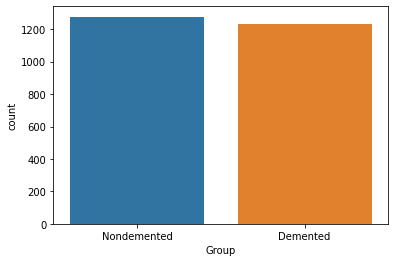

In [9]:
# Check the baseline after combining variables:
target='Group'
y=df[target]
print(y.value_counts(normalize=True))
sns.countplot(y);

In [10]:
# Split the dataset to Train/Validation and test:
train, test = train_test_split(df, train_size=0.8, test_size=0.2, stratify=df['Group'], random_state=42)
train, val = train_test_split(train, train_size=0.8, test_size=0.2, stratify=train['Group'], random_state=42)

train.shape, val.shape, test.shape

((1604, 12), (401, 12), (502, 12))

# Linear Model:

For linear model I will apply the $LogisticRegrission$.


## LogisticRegression:

In [11]:
# Set the features and the target:
target = 'Group'
features = ['Visit', 'M/F', 'Age', 'EDUC', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF']

# set X metrics features and y target vector:
Xtrain = train[features]
ytrain = train[target]

Xval = val[features]
yval = val[target]

# check the datasets shape:
Xtrain.shape, ytrain.shape, Xval.shape, yval.shape

((1604, 9), (1604,), (401, 9), (401,))

In [12]:
# Encoding the object columns:
encoder = ce.OneHotEncoder(use_cat_names=True)
Xtrain_en = encoder.fit_transform(Xtrain)
Xval_en = encoder.transform(Xval)

#Check the work:
Xtrain_en.head()

,Visit,M/F_M,M/F_F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
836,1,1,0,67,12,4,30,1440,0.727,1.219
436,1,0,1,73,12,3,30,1358,0.775,1.293
2191,2,1,0,77,16,2,30,1628,0.709,1.078
869,1,1,0,86,17,1,30,1720,0.705,1.020
1217,1,0,1,78,8,5,23,1462,0.691,1.200


In [13]:
scaler = StandardScaler()
Xtrain_sdr = scaler.fit_transform(Xtrain_en)
Xval_sdr = scaler.transform(Xval_en)

# Fit the model:
model = LogisticRegression(solver='lbfgs')
model.fit(Xtrain_sdr, ytrain)

# Predict the validation score:
ypred = model.predict(Xval_sdr)

print('The accuracy score :', accuracy_score(yval, ypred))

The accuracy score : 0.8079800498753117


In [14]:
# get the coefficient score:
coef = pd.Series(model.coef_[0], Xtrain_en.columns)
coef

Visit    0.013354
M/F_M   -0.230661
M/F_F    0.230661
Age      0.417748
EDUC     0.305858
SES      0.345423
MMSE     1.883711
eTIV     0.992853
nWBV     0.518142
ASF      0.598505
dtype: float64

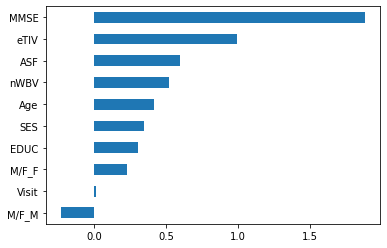

In [15]:
# Plot the coefficient:
coef.sort_values().plot.barh();

The graph above is the coefficient score of the features used, to show the relationship between each feature with the target.

# Tree Based Model:

For the tree based model, I will apply $RandomForest Classifier$

## Random Forest:

In [16]:
# Arrange X features matrix and y target vector:
target = 'Group'

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

X_test = test.drop(columns=target)
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape

((1604, 11), (1604,), (401, 11), (401,), (502, 11))

In [17]:
# Fit on train, and get validation score:

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    RandomForestClassifier(n_estimators=50, random_state=9, n_jobs=-1)
)

pipeline.fit(X_train, y_train)
print('The validation score : ', pipeline.score(X_val, y_val))

The validation score :  0.9276807980049875


In [18]:
# Test score:
test_score = pipeline.score(X_test, y_test)
test_score

0.9123505976095617

In [19]:
# PDP with one feature: Fit the model on our data:
features = df.columns.drop(['Group'])

encoder = ce.OrdinalEncoder()
X_train_en = encoder.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_en, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


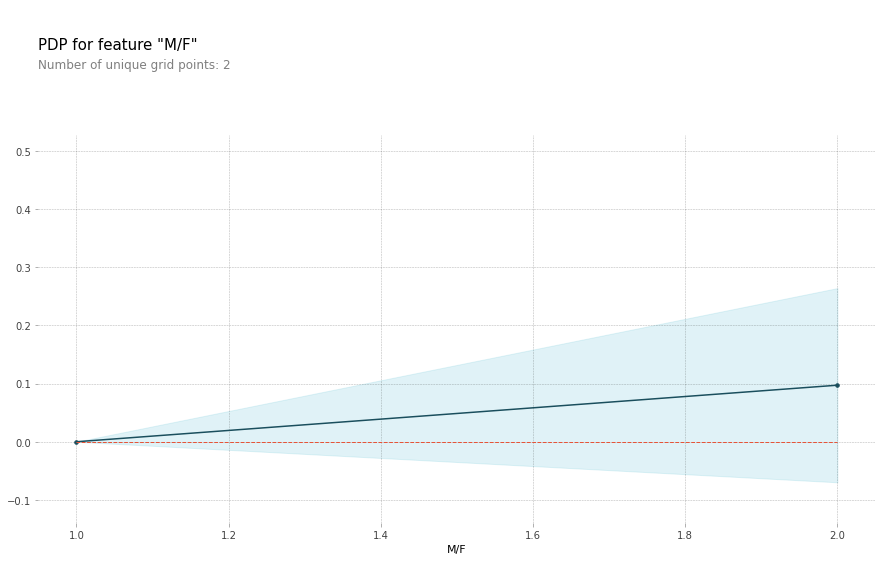

In [20]:
# Use Pdpbox Visualization:
feature = 'M/F'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_train_en, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [0]:
encoder.mapping
feature = 'M/F'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

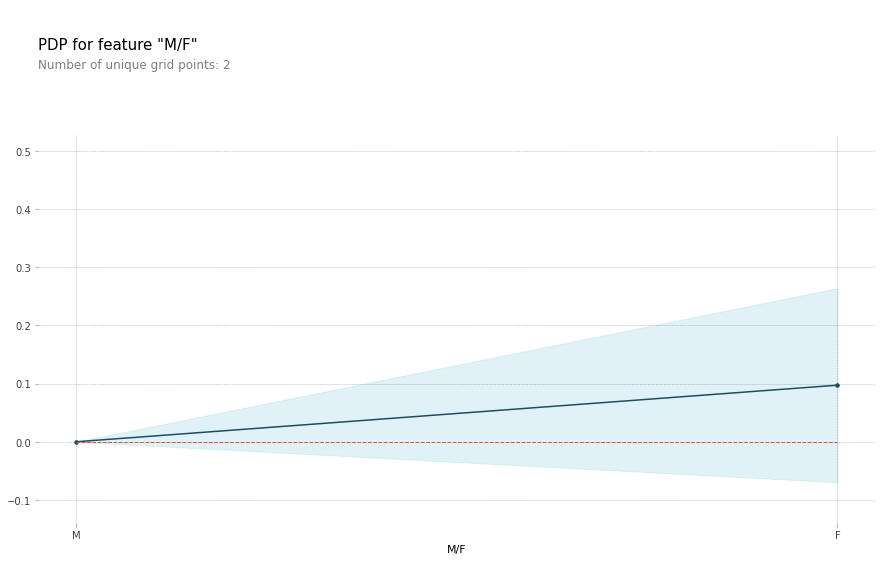

In [22]:
pdp.pdp_plot(pdp_dist, feature)

plt.xticks(category_codes, category_names);

Text(0.5, 1.0, 'Partial Dependence of Alzheimers patients, on gender & Age')

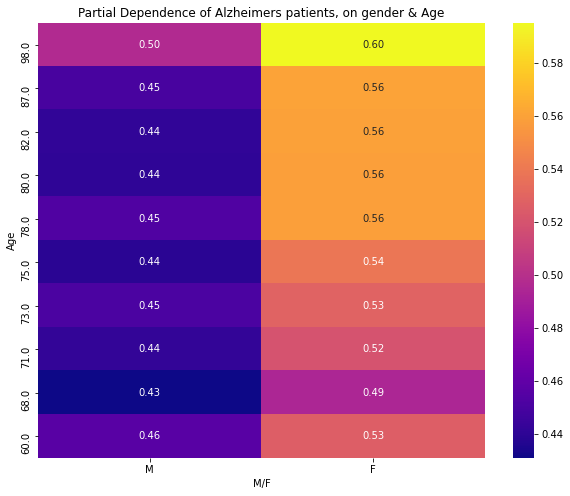

In [23]:
# PDP with features:
features = ['M/F', 'Age']

interaction = pdp_interact(
    model=model,
    dataset=X_train_en,
    model_features=X_train_en.columns,
    features=features
)

pdp = interaction.pdp.pivot_table(
    values='preds',
    columns=features[0], # Fisrt feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1] # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='plasma')
plt.title('Partial Dependence of Alzheimers patients, on gender & Age')

Looking at this heatmap, for each age category and gender these is a probability of being nondemented. For example, group between age 88 and 98 included, males have a 50% chance to be nondemented, for women in the same age category have 60% to be nondemented. In other words, males between age 88 and 98 have 50% chance to be demented, and women in the same category of age have 40% chance to be demented.

##Explain individual predictions with shapley value plots

In [24]:
# Start with XGBoost:

xgboost = make_pipeline(
    ce.OrdinalEncoder(),
    )

X_train_xgb = xgboost.fit_transform(X_train)
X_val_xgb = xgboost.transform(X_val)

eval_set = [(X_train_xgb, y_train), (X_val_xgb, y_val)]

model = XGBClassifier(n_estimator=100, n_jobs=-1)
model.fit(X_train_xgb, y_train, eval_set=eval_set, eval_metric='auc',
          early_stopping_rounds=10)

[0]	validation_0-auc:0.818975	validation_1-auc:0.836195
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.824535	validation_1-auc:0.845551
[2]	validation_0-auc:0.834879	validation_1-auc:0.850092
[3]	validation_0-auc:0.854911	validation_1-auc:0.856425
[4]	validation_0-auc:0.852879	validation_1-auc:0.861426
[5]	validation_0-auc:0.860604	validation_1-auc:0.87082
[6]	validation_0-auc:0.86586	validation_1-auc:0.875249
[7]	validation_0-auc:0.879186	validation_1-auc:0.887006
[8]	validation_0-auc:0.882472	validation_1-auc:0.893413
[9]	validation_0-auc:0.888384	validation_1-auc:0.901189
[10]	validation_0-auc:0.88984	validation_1-auc:0.902396
[11]	validation_0-auc:0.894074	validation_1-auc:0.909015
[12]	validation_0-auc:0.896825	validation_1-auc:0.911914
[13]	validation_0-auc:0.898589	validation_1-auc:0.913905
[14]	validation_0-auc:0.899204	validation_1-auc:0.914004
[

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimator=100,
              n_estimators=100, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [25]:
# Get the ROC AUC Score:
X_test_xgb = xgboost.transform(X_test)
y_test = test[target]
class_index = 1
y_pred_proba = model.predict_proba(X_test_xgb)[:, class_index]
print('Test ROC AUC for class {} :'.format(class_index))
print(roc_auc_score(y_test, y_pred_proba))

Test ROC AUC for class 1 :
0.9290920350609756


*Next step: let's check how our model was accurate on detecting Alzheimers:*

*1st we will merge our prediction and the actual data together, and test the model on one of the rows.*

In [0]:
# Convert the predictions to dataframe:
data = pd.DataFrame({
    'MRI ID' : X_test['MRI ID'],
    'Pred_proba' : y_pred_proba,
    'Group' : y_test
})

# Merge the dataframe predicted with the actual data:
data = data.merge(
    df[['MRI ID','Visit','M/F','Age','EDUC','SES','MMSE','eTIV','nWBV','ASF']],
    how = 'left'
)

In [27]:
data.head()

,MRI ID,Pred_proba,Group,Visit,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
0,OAS2_1841_MR1,0.211143,Demented,1,M,70,12,2,29,1432,0.692,1.225
1,OAS2_1860_MR1,0.300144,Nondemented,1,M,67,12,4,28,1412,0.783,1.243
2,OAS2_1521_MR1,0.850412,Nondemented,1,F,81,13,2,29,1345,0.737,1.305
3,OAS2_1124_MR1,0.378438,Demented,1,M,81,18,1,29,1647,0.717,1.066
4,OAS2_1555_MR1,0.929661,Nondemented,1,M,62,12,4,30,1378,0.795,1.274


In [0]:
# Choose the top probabilities greater than 80%:
nondemented = data['Group'] == 'Nondemented'
demented = ~nondemented
right = (nondemented) == (data['Pred_proba'] > 0.80)
wrong = ~right

In [29]:
data[nondemented & right].sample(n=5, random_state=1).sort_values(by='Pred_proba')

,MRI ID,Pred_proba,Group,Visit,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
175,OAS2_0069_MR2,0.835581,Nondemented,2,F,82,18,2,30,1471,0.690,1.193
56,OAS2_0536_MR1,0.841906,Nondemented,1,F,79,16,1,29,1354,0.739,1.297
218,OAS2_1898_MR2,0.887897,Nondemented,2,F,83,15,2,29,1482,0.751,1.184
282,OAS2_0529_MR1,0.906871,Nondemented,1,M,64,12,4,30,1370,0.794,1.281
343,OAS2_1965_MR1,0.924721,Nondemented,1,F,60,18,1,30,1402,0.822,1.252


In [30]:
# Check how our model did on this row:
row = X_test.iloc[[175]]
row

,Subject ID,MRI ID,Visit,M/F,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF
158,OAS2_0069,OAS2_0069_MR2,2,F,82,18,2,30,1471,0.69,1.193


In [31]:
import shap

explainer = shap.TreeExplainer(model)
row_xgb = xgboost.transform(row)
shap_values = explainer.shap_values(row_xgb)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row,
    link='logit'
)

Looking at this graph, our model was able to ditect this partient as $Nondemented$ with the probability of 84%.

In [32]:
# Now we will look at the features key that made out model to predict this patient is Nondemented
feature_names = row.columns
feature_values = row.values[0]
shaps = pd.Series(shap_values[0], zip(feature_names, feature_values))

pros = shaps.sort_values(ascending=False)[:3].index
cons = shaps.sort_values(ascending=True)[:3].index

# Let's print our pros and cons:
print('Top 3 reasons for Nondemented :')
for i, pro in enumerate(pros, start=1):
  feature_name, feature_value = pro
  print(feature_name,' is ', feature_value)

print('\n')

print('Cons :')
for i, con in enumerate(cons, start=1):
  feature_name, feature_value = con
  print(feature_name,' is ', feature_value)

Top 3 reasons for Nondemented :
EDUC  is  18
MMSE  is  30
M/F  is  F


Cons :
nWBV  is  0.69
ASF  is  1.193
SES  is  2


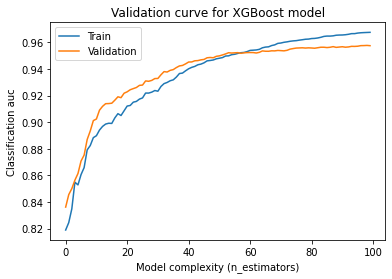

In [33]:
# Visualization of the relationship between the train and validation:

result = model.evals_result()
train_auc = result['validation_0']['auc']
val_auc = result['validation_1']['auc']

epoch = list(range(len(train_auc)))

plt.plot(epoch, train_auc, label='Train')
plt.plot(epoch, val_auc, label='Validation')
plt.ylabel('Classification auc')
plt.xlabel('Model complexity (n_estimators)')
plt.title('Validation curve for XGBoost model')
plt.legend()
plt.show()